# Transfer Learning Notebook

In [3]:
import numpy as np
import os
import optuna
import random

import matplotlib
from matplotlib import pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, Dropout, AveragePooling2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Rescaling
from keras import Input, models, backend as K
from tensorflow.keras import layers, models

print("Done!")

Done!


# Function Definitions and Variables

In [4]:
epochs = 12
img_rows, img_cols = 28, 28  # Image dimensions

def load(f):
    return np.load(f)['arr_0']
    
def initialize_data(train_im_file, test_im_file, train_lb_file, test_lb_file):
    train_images = load(train_im_file)
    test_images = load(test_im_file)
    train_labels = load(train_lb_file)
    test_labels = load(test_lb_file)
    
    if K.image_data_format() == 'channels_first':
        train_images = train_images.reshape(train_images.shape[0], 1, img_rows, img_cols)
        test_images = test_images.reshape(test_images.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
        test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    train_images = train_images.astype('float32')
    test_images = test_images.astype('float32')
    train_images /= 255
    test_images /= 255
    print('{} train samples, {} test samples'.format(len(train_images), len(test_images)))
    
    return tuple([train_images, test_images, train_labels, test_labels, input_shape])

# Helper to create the graphics
def create_visuals(graph_title, model_hist, test_images, test_labels):
    accuracy_data = model_hist.history['accuracy']
    val_accuracy_data = model_hist.history['val_accuracy']

    lower_bound = min(min(accuracy_data), min(val_accuracy_data))

    plt.plot(accuracy_data, label='Train Accuracy')
    plt.plot(val_accuracy_data, label = 'Validation Accuracy')

    plt.title(graph_title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([lower_bound - 0.01, 1])
    plt.legend(loc='lower right')

    print(accuracy_data[-1])
    print(val_accuracy_data[-1])
#     test_loss, test_acc = model_hist.evaluate(test_images, test_labels, verbose=2)

print("Done!")

Done!


## Load Data

In [5]:
prefix = '..\..\Datasets\\'
datasets = {
    "k49_tr_i" : prefix + 'Kuzushiji-49 - train-imgs.npz',
    "k49_te_i" : prefix + 'Kuzushiji-49 - test-imgs.npz',
    "k49_tr_l" : prefix + 'Kuzushiji-49 - train-labels.npz',
    "k49_te_l" : prefix + 'Kuzushiji-49 - test-labels.npz',
    "kanji" : prefix + 'modified_final_dataset',
}

# Load Kuzushiji-49 Data
dataset = initialize_data(datasets["k49_tr_i"], datasets["k49_te_i"], datasets["k49_tr_l"], datasets["k49_te_l"])
k49_train_images = dataset[0]
k49_test_images = dataset[1]
k49_train_labels = dataset[2]
k49_test_labels  = dataset[3]
k49_input_shape = dataset[4]

# Load Kanji Data
kanji_size = (28, 28)
data_path = datasets["kanji"]
kanji_train = tf.keras.utils.image_dataset_from_directory(data_path, validation_split=0.3, seed=222,
                            subset="training", color_mode="grayscale", image_size=kanji_size, batch_size=32)

kanji_val = tf.keras.utils.image_dataset_from_directory(data_path, validation_split=0.3, seed=222,
                          subset="validation", color_mode="grayscale", image_size=kanji_size, batch_size=32)

print("Done!")

232365 train samples, 38547 test samples
Found 70599 files belonging to 150 classes.
Using 49420 files for training.
Found 70599 files belonging to 150 classes.
Using 21179 files for validation.
Done!


### Rescale Kanji Data and Training Performance Optimizations

In [6]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = kanji_train.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))    # Pixel values are now in `[0,1]`

0.0 1.0


In [7]:
AUTOTUNE = tf.data.AUTOTUNE

kanji_train = kanji_train.cache().prefetch(buffer_size=AUTOTUNE)
kanji_val = kanji_val.cache().prefetch(buffer_size=AUTOTUNE)
print("Done!")

Done!


## K49 Base Model and Results

In [8]:
k49_classes = 49

k49_2 = Sequential()
k49_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=k49_input_shape))
k49_2.add(Conv2D(64, (3, 3), activation='relu', input_shape=k49_input_shape))
k49_2.add(Dropout(0.25))
k49_2.add(AveragePooling2D(pool_size=(2, 2), strides=None, padding="valid"))
k49_2.add(Conv2D(48, (3, 3), activation='relu', input_shape=k49_input_shape))
k49_2.add(Flatten())
k49_2.add(Dense(k49_classes, activation='relu'))
k49_2.add(Dense(k49_classes))

k49_2.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam",
              metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), 'accuracy'])

k49_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 average_pooling2d (AverageP  (None, 12, 12, 64)       0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 48)        27696     
                                                                 
 flatten (Flatten)           (None, 4800)              0         
                                                        

In [9]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

k49_2_history = k49_2.fit(k49_train_images, k49_train_labels, batch_size=128, epochs=epochs,
              callbacks=callback, verbose=1, validation_data=(k49_test_images, k49_test_labels))

# k49_2.save('k49_2_model')

Epoch 1/12
1816/1816 [==============================] - 640s 351ms/step - loss: 0.6065 - sparse_categorical_crossentropy: 2.8732 - accuracy: 0.8415 - val_loss: 0.5832 - val_sparse_categorical_crossentropy: 2.7669 - val_accuracy: 0.8490
Epoch 2/12
1816/1816 [==============================] - 636s 350ms/step - loss: 0.2442 - sparse_categorical_crossentropy: 2.5433 - accuracy: 0.9329 - val_loss: 0.4318 - val_sparse_categorical_crossentropy: 2.6203 - val_accuracy: 0.8908
Epoch 3/12
1816/1816 [==============================] - 626s 345ms/step - loss: 0.1763 - sparse_categorical_crossentropy: 2.4544 - accuracy: 0.9510 - val_loss: 0.3948 - val_sparse_categorical_crossentropy: 2.5290 - val_accuracy: 0.8997
Epoch 4/12
1816/1816 [==============================] - 685s 377ms/step - loss: 0.1392 - sparse_categorical_crossentropy: 2.3800 - accuracy: 0.9601 - val_loss: 0.4055 - val_sparse_categorical_crossentropy: 2.5016 - val_accuracy: 0.9014
Epoch 5/12
1816/1816 [==============================] - 

0.9778538346290588
0.9126780033111572


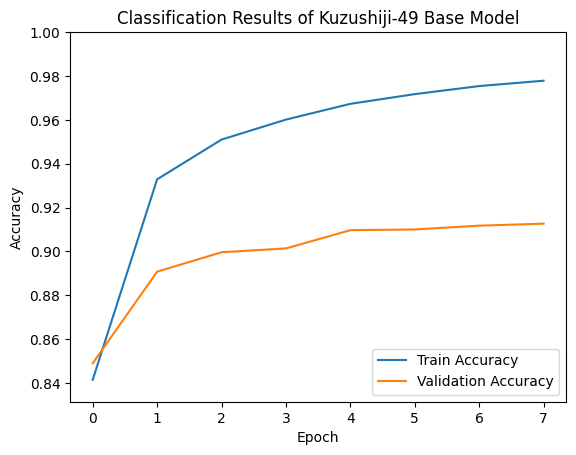

In [11]:
create_visuals("Classification Results of Kuzushiji-49 Base Model", k49_2_history, k49_test_images, k49_train_labels)

## Create the Transfer Learning Model

In [14]:
# The original Kanji dataset contains images that are 64x64. Since we are transferring the learning
#   from models that trained on 28x28 images, the Kanji images must be downscaled accordingly.
import os
import random
from skimage.transform import rescale
from skimage import io

def attempt_load(name):
    if os.path.isdir(name):
        return models.load_model(name)
    else:
        print(f"Invalid model name {name}")
        
# Returns a list of the names of the copied directories 
def replicate_folder_structure(original_data, write_path):
    for root, directory, files in os.walk(original_data):
        for direc in directory:
            os.mkdir(write_path + '\\' + direc)

# Scale the image to the desired size
def rescale_image(load_path, save_path, image_scale):
    kanji_char = io.imread(load_path)
    rescaled_image = rescale(kanji_char, image_scale, anti_aliasing=True, clip=True)
    io.imsave(save_path, rescaled_image)

In [15]:
tl_base = attempt_load("k49_2_model")
tl_base.pop()
tl_base.pop()
tl_base.pop()
tl_base.trainable = False

tl_base.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 dropout_2 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 average_pooling2d_2 (Averag  (None, 12, 12, 64)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 48)        27696     
                                                                 
Total params: 46,512
Trainable params: 0
Non-trainable params: 46,512
__________________________________________________

In [18]:
in_shape = (28, 28, 1)

tl_model = Sequential()
tl_model.add(tl_base)                              # Base..
tl_model.add(Conv2D(48, (3, 3), activation='sigmoid', input_shape=in_shape))
tl_model.add(AveragePooling2D(pool_size=(2, 2)))
tl_model.add(Dropout(0.2))
tl_model.add(Conv2D(32, (3, 3), activation='sigmoid'))
tl_model.add(Flatten())
tl_model.add(Dense(150, activation='relu'))
tl_model.add(Dense(150))

tl_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 10, 10, 48)        46512     
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 48)          20784     
                                                                 
 average_pooling2d_2 (Averag  (None, 4, 4, 48)         0         
 ePooling2D)                                                     
                                                                 
 dropout_2 (Dropout)         (None, 4, 4, 48)          0         
                                                                 
 conv2d_6 (Conv2D)           (None, 2, 2, 32)          13856     
                                                                 
 flatten_2 (Flatten)         (None, 128)               0         
                                                      

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

tl_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer="adam",
                  metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), 'accuracy'])

tl_model_history = tl_model.fit(kanji_train, batch_size=128, epochs=epochs,
              callbacks=callback, verbose=1, validation_data=kanji_val)

# tl_model.save('tl_model.h5', save_format='h5')

Epoch 1/12
1545/1545 [==============================] - 115s 73ms/step - loss: 2.0925 - sparse_categorical_crossentropy: 4.9825 - accuracy: 0.5289 - val_loss: 0.9316 - val_sparse_categorical_crossentropy: 2.3766 - val_accuracy: 0.7605
Epoch 2/12
1545/1545 [==============================] - 82s 53ms/step - loss: 0.8268 - sparse_categorical_crossentropy: 2.2064 - accuracy: 0.7877 - val_loss: 0.6244 - val_sparse_categorical_crossentropy: 1.7371 - val_accuracy: 0.8375
Epoch 3/12
1545/1545 [==============================] - 81s 53ms/step - loss: 0.6267 - sparse_categorical_crossentropy: 1.7654 - accuracy: 0.8348 - val_loss: 0.5064 - val_sparse_categorical_crossentropy: 1.4735 - val_accuracy: 0.8671
Epoch 4/12
1545/1545 [==============================] - 78s 51ms/step - loss: 0.5192 - sparse_categorical_crossentropy: 1.5557 - accuracy: 0.8642 - val_loss: 0.4416 - val_sparse_categorical_crossentropy: 1.3957 - val_accuracy: 0.8832
Epoch 5/12
1545/1545 [==============================] - 78s 50m

0.9232901930809021
0.924075722694397


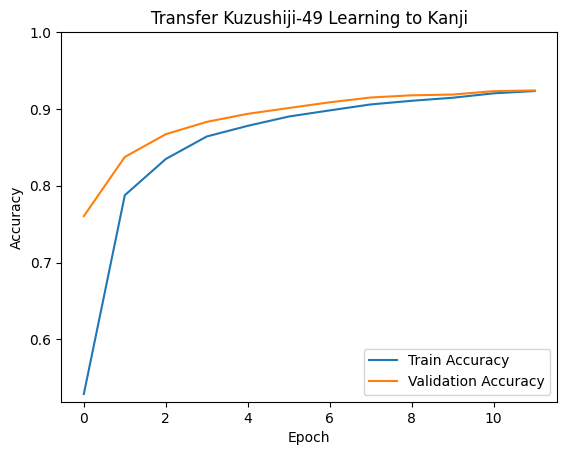

In [20]:
create_visuals("Transfer Kuzushiji-49 Learning to Kanji", tl_model_history, 1, 1)

### Optuna Model

In [23]:
def load_base_model(filename):
    bm = attempt_load(filename)
    bm.pop()
    bm.pop()
    bm.pop()
    bm.trainable = False
    return bm
    

def objective(trial):
    # The following is where you suggest your search space per trial (integer, categorical and floating point values)
    l1_filters = trial.suggest_int('first_layer_kernel', 48, 64)
    l1_activation = trial.suggest_categorical('first_layer_activation', ['relu', 'sigmoid', 'tanh'])
    l2_filters = trial.suggest_int('second_layer_kernel', 28, 44)
    l2_activation = trial.suggest_categorical('second_layer_activation', ['relu', 'sigmoid', 'tanh'])
    average_pooling_size = trial.suggest_int('average_pooling_size', 2, 2)
    dense_layer_size = trial.suggest_int('dense_layer_size', 140, 180)
    dense_layer_activation = trial.suggest_categorical('dense_layer_activation', ['relu', 'sigmoid', 'tanh'])
    
    # Load the frozen base model
    base_model = load_base_model('k49_2_model')
    mod_in_shape = (28, 28, 1)
    
    model = Sequential()
    model.add(base_model)
    model.add(Conv2D(l1_filters, (3, 3), activation=l1_activation, input_shape=mod_in_shape))
    model.add(AveragePooling2D((average_pooling_size, average_pooling_size)))
    model.add(Dropout(0.2))
    model.add(Conv2D(l2_filters, (3, 3), activation=l2_activation, input_shape=mod_in_shape))
    model.add(Flatten())
    model.add(Dense(dense_layer_size, activation=dense_layer_activation))
    model.add(Dense(150))

    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), 'accuracy'])

#     print(model.summary())

    callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

    history = model.fit(kanji_train, epochs=15,
                    callbacks=callback, validation_data=kanji_val)

    # Following line is very important as this is the metric that optuna uses to optimize over
    return history.history['val_accuracy'][-1]

# Run a study
study = optuna.create_study(direction='maximize', study_name="Study1")
study.optimize(objective, n_trials=20)

[I 2022-11-29 07:55:44,298] A new study created in memory with name: Study1


Epoch 1/15
1545/1545 [==============================] - 113s 71ms/step - loss: 2.7260 - sparse_categorical_crossentropy: 5.2670 - accuracy: 0.4340 - val_loss: 1.3889 - val_sparse_categorical_crossentropy: 2.8856 - val_accuracy: 0.6948
Epoch 2/15
1545/1545 [==============================] - 109s 71ms/step - loss: 1.0757 - sparse_categorical_crossentropy: 2.6253 - accuracy: 0.7577 - val_loss: 0.7894 - val_sparse_categorical_crossentropy: 2.3708 - val_accuracy: 0.8180
Epoch 3/15
1545/1545 [==============================] - 107s 69ms/step - loss: 0.7400 - sparse_categorical_crossentropy: 2.2649 - accuracy: 0.8263 - val_loss: 0.5982 - val_sparse_categorical_crossentropy: 2.1072 - val_accuracy: 0.8579
Epoch 4/15
1545/1545 [==============================] - 107s 69ms/step - loss: 0.5938 - sparse_categorical_crossentropy: 2.0444 - accuracy: 0.8568 - val_loss: 0.5064 - val_sparse_categorical_crossentropy: 1.9341 - val_accuracy: 0.8745
Epoch 5/15
1545/1545 [==============================] - 107s

[I 2022-11-29 08:22:20,769] Trial 0 finished with value: 0.9227536916732788 and parameters: {'first_layer_kernel': 57, 'first_layer_activation': 'tanh', 'second_layer_kernel': 38, 'second_layer_activation': 'sigmoid', 'average_pooling_size': 2, 'dense_layer_size': 140, 'dense_layer_activation': 'sigmoid'}. Best is trial 0 with value: 0.9227536916732788.


Epoch 1/15
1545/1545 [==============================] - 75s 48ms/step - loss: 2.0325 - sparse_categorical_crossentropy: 4.0569 - accuracy: 0.5898 - val_loss: 0.8856 - val_sparse_categorical_crossentropy: 2.3960 - val_accuracy: 0.8082
Epoch 2/15
1545/1545 [==============================] - 75s 49ms/step - loss: 0.7363 - sparse_categorical_crossentropy: 2.1934 - accuracy: 0.8343 - val_loss: 0.5491 - val_sparse_categorical_crossentropy: 2.0332 - val_accuracy: 0.8728
Epoch 3/15
1545/1545 [==============================] - 75s 48ms/step - loss: 0.5376 - sparse_categorical_crossentropy: 1.9183 - accuracy: 0.8723 - val_loss: 0.4477 - val_sparse_categorical_crossentropy: 1.8413 - val_accuracy: 0.8909
Epoch 4/15
1545/1545 [==============================] - 75s 48ms/step - loss: 0.4515 - sparse_categorical_crossentropy: 1.7535 - accuracy: 0.8888 - val_loss: 0.3945 - val_sparse_categorical_crossentropy: 1.7326 - val_accuracy: 0.9031
Epoch 5/15
1545/1545 [==============================] - 75s 48ms

[I 2022-11-29 08:41:06,983] Trial 1 finished with value: 0.9259644150733948 and parameters: {'first_layer_kernel': 48, 'first_layer_activation': 'tanh', 'second_layer_kernel': 43, 'second_layer_activation': 'tanh', 'average_pooling_size': 2, 'dense_layer_size': 164, 'dense_layer_activation': 'sigmoid'}. Best is trial 1 with value: 0.9259644150733948.


Epoch 1/15
1545/1545 [==============================] - 79s 50ms/step - loss: 1.7983 - sparse_categorical_crossentropy: 4.7257 - accuracy: 0.6096 - val_loss: 0.7259 - val_sparse_categorical_crossentropy: 4.1322 - val_accuracy: 0.8279
Epoch 2/15
1545/1545 [==============================] - 78s 50ms/step - loss: 0.6272 - sparse_categorical_crossentropy: 4.1340 - accuracy: 0.8460 - val_loss: 0.4841 - val_sparse_categorical_crossentropy: 4.1319 - val_accuracy: 0.8778
Epoch 3/15
1545/1545 [==============================] - 78s 50ms/step - loss: 0.4655 - sparse_categorical_crossentropy: 4.1306 - accuracy: 0.8825 - val_loss: 0.3975 - val_sparse_categorical_crossentropy: 4.1373 - val_accuracy: 0.8996
Epoch 4/15
1545/1545 [==============================] - 78s 51ms/step - loss: 0.3894 - sparse_categorical_crossentropy: 4.1314 - accuracy: 0.8991 - val_loss: 0.3532 - val_sparse_categorical_crossentropy: 4.1404 - val_accuracy: 0.9055
Epoch 5/15
1545/1545 [==============================] - 78s 51ms

[I 2022-11-29 09:00:38,931] Trial 2 finished with value: 0.934605062007904 and parameters: {'first_layer_kernel': 61, 'first_layer_activation': 'sigmoid', 'second_layer_kernel': 39, 'second_layer_activation': 'sigmoid', 'average_pooling_size': 2, 'dense_layer_size': 168, 'dense_layer_activation': 'tanh'}. Best is trial 2 with value: 0.934605062007904.


Epoch 1/15
1545/1545 [==============================] - 79s 51ms/step - loss: 3.0185 - sparse_categorical_crossentropy: 7.4025 - accuracy: 0.3661 - val_loss: 1.8961 - val_sparse_categorical_crossentropy: 4.2633 - val_accuracy: 0.5697
Epoch 2/15
1545/1545 [==============================] - 77s 50ms/step - loss: 1.5697 - sparse_categorical_crossentropy: 3.5256 - accuracy: 0.6288 - val_loss: 1.3067 - val_sparse_categorical_crossentropy: 3.1007 - val_accuracy: 0.6778
Epoch 3/15
1545/1545 [==============================] - 77s 50ms/step - loss: 1.2387 - sparse_categorical_crossentropy: 2.8748 - accuracy: 0.6947 - val_loss: 1.1012 - val_sparse_categorical_crossentropy: 2.6487 - val_accuracy: 0.7241
Epoch 4/15
1545/1545 [==============================] - 71s 46ms/step - loss: 1.1216 - sparse_categorical_crossentropy: 2.6844 - accuracy: 0.7186 - val_loss: 1.1013 - val_sparse_categorical_crossentropy: 2.7332 - val_accuracy: 0.7222
Epoch 5/15
1545/1545 [==============================] - 71s 46ms

[I 2022-11-29 09:14:39,374] Trial 3 finished with value: 0.7562207579612732 and parameters: {'first_layer_kernel': 62, 'first_layer_activation': 'relu', 'second_layer_kernel': 43, 'second_layer_activation': 'relu', 'average_pooling_size': 2, 'dense_layer_size': 147, 'dense_layer_activation': 'sigmoid'}. Best is trial 2 with value: 0.934605062007904.


Epoch 1/15
1545/1545 [==============================] - 49s 32ms/step - loss: 1.3758 - sparse_categorical_crossentropy: 3.4019 - accuracy: 0.6838 - val_loss: 0.5940 - val_sparse_categorical_crossentropy: 1.6109 - val_accuracy: 0.8455
Epoch 2/15
1545/1545 [==============================] - 49s 32ms/step - loss: 0.5815 - sparse_categorical_crossentropy: 1.6765 - accuracy: 0.8477 - val_loss: 0.4333 - val_sparse_categorical_crossentropy: 1.3367 - val_accuracy: 0.8862
Epoch 3/15
1545/1545 [==============================] - 50s 32ms/step - loss: 0.4520 - sparse_categorical_crossentropy: 1.3761 - accuracy: 0.8796 - val_loss: 0.3885 - val_sparse_categorical_crossentropy: 1.2312 - val_accuracy: 0.8979
Epoch 4/15
1545/1545 [==============================] - 50s 32ms/step - loss: 0.3958 - sparse_categorical_crossentropy: 1.2657 - accuracy: 0.8930 - val_loss: 0.3614 - val_sparse_categorical_crossentropy: 1.1644 - val_accuracy: 0.9074
Epoch 5/15
1545/1545 [==============================] - 50s 33ms

[I 2022-11-29 09:27:29,477] Trial 4 finished with value: 0.9229425191879272 and parameters: {'first_layer_kernel': 48, 'first_layer_activation': 'tanh', 'second_layer_kernel': 31, 'second_layer_activation': 'tanh', 'average_pooling_size': 2, 'dense_layer_size': 153, 'dense_layer_activation': 'relu'}. Best is trial 2 with value: 0.934605062007904.


Epoch 1/15
1545/1545 [==============================] - 56s 36ms/step - loss: 1.6425 - sparse_categorical_crossentropy: 4.5597 - accuracy: 0.6474 - val_loss: 0.6746 - val_sparse_categorical_crossentropy: 4.1168 - val_accuracy: 0.8413
Epoch 2/15
1545/1545 [==============================] - 56s 36ms/step - loss: 0.6019 - sparse_categorical_crossentropy: 4.1269 - accuracy: 0.8527 - val_loss: 0.4713 - val_sparse_categorical_crossentropy: 4.1314 - val_accuracy: 0.8798
Epoch 3/15
1545/1545 [==============================] - 56s 36ms/step - loss: 0.4652 - sparse_categorical_crossentropy: 4.1301 - accuracy: 0.8826 - val_loss: 0.3909 - val_sparse_categorical_crossentropy: 4.1346 - val_accuracy: 0.9004
Epoch 4/15
1545/1545 [==============================] - 56s 36ms/step - loss: 0.3892 - sparse_categorical_crossentropy: 4.1322 - accuracy: 0.8997 - val_loss: 0.3518 - val_sparse_categorical_crossentropy: 4.1415 - val_accuracy: 0.9086
Epoch 5/15
1545/1545 [==============================] - 58s 37ms

[I 2022-11-29 09:41:23,740] Trial 5 finished with value: 0.9274753332138062 and parameters: {'first_layer_kernel': 54, 'first_layer_activation': 'tanh', 'second_layer_kernel': 34, 'second_layer_activation': 'sigmoid', 'average_pooling_size': 2, 'dense_layer_size': 156, 'dense_layer_activation': 'tanh'}. Best is trial 2 with value: 0.934605062007904.


Epoch 1/15
1545/1545 [==============================] - 55s 35ms/step - loss: 4.1831 - sparse_categorical_crossentropy: 8.4750 - accuracy: 0.1462 - val_loss: 3.2200 - val_sparse_categorical_crossentropy: 4.5848 - val_accuracy: 0.2841
Epoch 2/15
1545/1545 [==============================] - 55s 35ms/step - loss: 2.6285 - sparse_categorical_crossentropy: 4.3012 - accuracy: 0.3827 - val_loss: 2.1647 - val_sparse_categorical_crossentropy: 4.2028 - val_accuracy: 0.4723
Epoch 3/15
1545/1545 [==============================] - 58s 37ms/step - loss: 2.1020 - sparse_categorical_crossentropy: 4.2458 - accuracy: 0.4828 - val_loss: 1.8327 - val_sparse_categorical_crossentropy: 4.2236 - val_accuracy: 0.5432
Epoch 4/15
1545/1545 [==============================] - 55s 36ms/step - loss: 1.8067 - sparse_categorical_crossentropy: 4.2472 - accuracy: 0.5452 - val_loss: 1.6561 - val_sparse_categorical_crossentropy: 4.2403 - val_accuracy: 0.5778
Epoch 5/15
1545/1545 [==============================] - 55s 36ms

[I 2022-11-29 09:54:19,166] Trial 6 finished with value: 0.6075357794761658 and parameters: {'first_layer_kernel': 61, 'first_layer_activation': 'relu', 'second_layer_kernel': 41, 'second_layer_activation': 'relu', 'average_pooling_size': 2, 'dense_layer_size': 156, 'dense_layer_activation': 'tanh'}. Best is trial 2 with value: 0.934605062007904.


Epoch 1/15
1545/1545 [==============================] - 55s 35ms/step - loss: 3.0511 - sparse_categorical_crossentropy: 7.5797 - accuracy: 0.3605 - val_loss: 1.7597 - val_sparse_categorical_crossentropy: 4.1133 - val_accuracy: 0.5934
Epoch 2/15
1545/1545 [==============================] - 54s 35ms/step - loss: 1.5255 - sparse_categorical_crossentropy: 3.5756 - accuracy: 0.6350 - val_loss: 1.2916 - val_sparse_categorical_crossentropy: 3.2827 - val_accuracy: 0.6835
Epoch 3/15
1545/1545 [==============================] - 54s 35ms/step - loss: 1.2194 - sparse_categorical_crossentropy: 3.1282 - accuracy: 0.7001 - val_loss: 1.0902 - val_sparse_categorical_crossentropy: 2.9336 - val_accuracy: 0.7261
Epoch 4/15
1545/1545 [==============================] - 55s 35ms/step - loss: 1.1140 - sparse_categorical_crossentropy: 3.1413 - accuracy: 0.7161 - val_loss: 1.0346 - val_sparse_categorical_crossentropy: 3.3168 - val_accuracy: 0.7368
Epoch 5/15
1545/1545 [==============================] - 54s 35ms

[I 2022-11-29 10:06:07,501] Trial 7 finished with value: 0.7721327543258667 and parameters: {'first_layer_kernel': 59, 'first_layer_activation': 'relu', 'second_layer_kernel': 32, 'second_layer_activation': 'relu', 'average_pooling_size': 2, 'dense_layer_size': 162, 'dense_layer_activation': 'sigmoid'}. Best is trial 2 with value: 0.934605062007904.


Epoch 1/15
1545/1545 [==============================] - 56s 36ms/step - loss: 1.4659 - sparse_categorical_crossentropy: 4.4489 - accuracy: 0.6910 - val_loss: 0.5686 - val_sparse_categorical_crossentropy: 4.1202 - val_accuracy: 0.8684
Epoch 2/15
1545/1545 [==============================] - 55s 35ms/step - loss: 0.5205 - sparse_categorical_crossentropy: 4.1245 - accuracy: 0.8730 - val_loss: 0.3797 - val_sparse_categorical_crossentropy: 4.1438 - val_accuracy: 0.9075
Epoch 3/15
1545/1545 [==============================] - 55s 36ms/step - loss: 0.3993 - sparse_categorical_crossentropy: 4.1360 - accuracy: 0.8981 - val_loss: 0.3304 - val_sparse_categorical_crossentropy: 4.1498 - val_accuracy: 0.9162
Epoch 4/15
1545/1545 [==============================] - 55s 36ms/step - loss: 0.3429 - sparse_categorical_crossentropy: 4.1400 - accuracy: 0.9120 - val_loss: 0.3032 - val_sparse_categorical_crossentropy: 4.1535 - val_accuracy: 0.9215
Epoch 5/15
1545/1545 [==============================] - 55s 35ms

[I 2022-11-29 10:19:51,803] Trial 8 finished with value: 0.934605062007904 and parameters: {'first_layer_kernel': 62, 'first_layer_activation': 'sigmoid', 'second_layer_kernel': 43, 'second_layer_activation': 'tanh', 'average_pooling_size': 2, 'dense_layer_size': 145, 'dense_layer_activation': 'tanh'}. Best is trial 2 with value: 0.934605062007904.


Epoch 1/15
1545/1545 [==============================] - 54s 35ms/step - loss: 3.1049 - sparse_categorical_crossentropy: 7.7609 - accuracy: 0.3063 - val_loss: 2.0311 - val_sparse_categorical_crossentropy: 5.1937 - val_accuracy: 0.4902
Epoch 2/15
1545/1545 [==============================] - 54s 35ms/step - loss: 1.9262 - sparse_categorical_crossentropy: 4.8124 - accuracy: 0.5187 - val_loss: 1.6440 - val_sparse_categorical_crossentropy: 4.1111 - val_accuracy: 0.5805
Epoch 3/15
1545/1545 [==============================] - 54s 35ms/step - loss: 1.5987 - sparse_categorical_crossentropy: 3.9671 - accuracy: 0.5913 - val_loss: 1.3647 - val_sparse_categorical_crossentropy: 3.4374 - val_accuracy: 0.6501
Epoch 4/15
1545/1545 [==============================] - 53s 35ms/step - loss: 1.4082 - sparse_categorical_crossentropy: 3.5274 - accuracy: 0.6328 - val_loss: 1.2005 - val_sparse_categorical_crossentropy: 2.9945 - val_accuracy: 0.6893
Epoch 5/15
1545/1545 [==============================] - 54s 35ms

[I 2022-11-29 10:33:27,273] Trial 9 finished with value: 0.7612257599830627 and parameters: {'first_layer_kernel': 58, 'first_layer_activation': 'relu', 'second_layer_kernel': 34, 'second_layer_activation': 'tanh', 'average_pooling_size': 2, 'dense_layer_size': 147, 'dense_layer_activation': 'relu'}. Best is trial 2 with value: 0.934605062007904.


Epoch 1/15
1545/1545 [==============================] - 53s 34ms/step - loss: 1.8400 - sparse_categorical_crossentropy: 4.7814 - accuracy: 0.5975 - val_loss: 0.7389 - val_sparse_categorical_crossentropy: 4.1451 - val_accuracy: 0.8225
Epoch 2/15
1545/1545 [==============================] - 53s 34ms/step - loss: 0.6456 - sparse_categorical_crossentropy: 4.1374 - accuracy: 0.8407 - val_loss: 0.4883 - val_sparse_categorical_crossentropy: 4.1472 - val_accuracy: 0.8781
Epoch 3/15
1545/1545 [==============================] - 53s 34ms/step - loss: 0.4808 - sparse_categorical_crossentropy: 4.1402 - accuracy: 0.8791 - val_loss: 0.3946 - val_sparse_categorical_crossentropy: 4.1463 - val_accuracy: 0.8971
Epoch 4/15
1545/1545 [==============================] - 53s 34ms/step - loss: 0.4055 - sparse_categorical_crossentropy: 4.1389 - accuracy: 0.8949 - val_loss: 0.3549 - val_sparse_categorical_crossentropy: 4.1481 - val_accuracy: 0.9074
Epoch 5/15
1545/1545 [==============================] - 53s 34ms

[I 2022-11-29 10:46:39,804] Trial 10 finished with value: 0.9358798861503601 and parameters: {'first_layer_kernel': 53, 'first_layer_activation': 'sigmoid', 'second_layer_kernel': 38, 'second_layer_activation': 'sigmoid', 'average_pooling_size': 2, 'dense_layer_size': 175, 'dense_layer_activation': 'tanh'}. Best is trial 10 with value: 0.9358798861503601.


Epoch 1/15
1545/1545 [==============================] - 54s 34ms/step - loss: 1.8209 - sparse_categorical_crossentropy: 4.7255 - accuracy: 0.6038 - val_loss: 0.7199 - val_sparse_categorical_crossentropy: 4.1412 - val_accuracy: 0.8291
Epoch 2/15
1545/1545 [==============================] - 53s 34ms/step - loss: 0.6421 - sparse_categorical_crossentropy: 4.1305 - accuracy: 0.8410 - val_loss: 0.4800 - val_sparse_categorical_crossentropy: 4.1388 - val_accuracy: 0.8802
Epoch 3/15
1545/1545 [==============================] - 52s 34ms/step - loss: 0.4768 - sparse_categorical_crossentropy: 4.1311 - accuracy: 0.8791 - val_loss: 0.4009 - val_sparse_categorical_crossentropy: 4.1480 - val_accuracy: 0.8969
Epoch 4/15
1545/1545 [==============================] - 53s 34ms/step - loss: 0.3964 - sparse_categorical_crossentropy: 4.1348 - accuracy: 0.8968 - val_loss: 0.3402 - val_sparse_categorical_crossentropy: 4.1491 - val_accuracy: 0.9130
Epoch 5/15
1545/1545 [==============================] - 52s 34ms

[I 2022-11-29 10:59:49,990] Trial 11 finished with value: 0.9354076981544495 and parameters: {'first_layer_kernel': 53, 'first_layer_activation': 'sigmoid', 'second_layer_kernel': 39, 'second_layer_activation': 'sigmoid', 'average_pooling_size': 2, 'dense_layer_size': 176, 'dense_layer_activation': 'tanh'}. Best is trial 10 with value: 0.9358798861503601.


Epoch 1/15
1545/1545 [==============================] - 53s 34ms/step - loss: 1.9244 - sparse_categorical_crossentropy: 4.7922 - accuracy: 0.5773 - val_loss: 0.8243 - val_sparse_categorical_crossentropy: 4.1435 - val_accuracy: 0.7992
Epoch 2/15
1545/1545 [==============================] - 52s 34ms/step - loss: 0.7249 - sparse_categorical_crossentropy: 4.1439 - accuracy: 0.8198 - val_loss: 0.5315 - val_sparse_categorical_crossentropy: 4.1397 - val_accuracy: 0.8649
Epoch 3/15
1545/1545 [==============================] - 52s 34ms/step - loss: 0.5390 - sparse_categorical_crossentropy: 4.1403 - accuracy: 0.8626 - val_loss: 0.4355 - val_sparse_categorical_crossentropy: 4.1386 - val_accuracy: 0.8872
Epoch 4/15
1545/1545 [==============================] - 52s 34ms/step - loss: 0.4507 - sparse_categorical_crossentropy: 4.1383 - accuracy: 0.8828 - val_loss: 0.3877 - val_sparse_categorical_crossentropy: 4.1441 - val_accuracy: 0.8995
Epoch 5/15
1545/1545 [==============================] - 52s 34ms

[I 2022-11-29 11:12:54,991] Trial 12 finished with value: 0.9310637712478638 and parameters: {'first_layer_kernel': 52, 'first_layer_activation': 'sigmoid', 'second_layer_kernel': 28, 'second_layer_activation': 'sigmoid', 'average_pooling_size': 2, 'dense_layer_size': 180, 'dense_layer_activation': 'tanh'}. Best is trial 10 with value: 0.9358798861503601.


Epoch 1/15
1545/1545 [==============================] - 57s 36ms/step - loss: 1.8321 - sparse_categorical_crossentropy: 4.7008 - accuracy: 0.5995 - val_loss: 0.7428 - val_sparse_categorical_crossentropy: 4.1458 - val_accuracy: 0.8232
Epoch 2/15
1545/1545 [==============================] - 56s 36ms/step - loss: 0.6603 - sparse_categorical_crossentropy: 4.1380 - accuracy: 0.8359 - val_loss: 0.4912 - val_sparse_categorical_crossentropy: 4.1410 - val_accuracy: 0.8780
Epoch 3/15
1545/1545 [==============================] - 56s 36ms/step - loss: 0.4910 - sparse_categorical_crossentropy: 4.1394 - accuracy: 0.8747 - val_loss: 0.4006 - val_sparse_categorical_crossentropy: 4.1447 - val_accuracy: 0.8988
Epoch 4/15
1545/1545 [==============================] - 56s 36ms/step - loss: 0.4160 - sparse_categorical_crossentropy: 4.1354 - accuracy: 0.8916 - val_loss: 0.3565 - val_sparse_categorical_crossentropy: 4.1454 - val_accuracy: 0.9078
Epoch 5/15
1545/1545 [==============================] - 55s 36ms

[I 2022-11-29 11:26:48,285] Trial 13 finished with value: 0.9340856671333313 and parameters: {'first_layer_kernel': 52, 'first_layer_activation': 'sigmoid', 'second_layer_kernel': 37, 'second_layer_activation': 'sigmoid', 'average_pooling_size': 2, 'dense_layer_size': 177, 'dense_layer_activation': 'tanh'}. Best is trial 10 with value: 0.9358798861503601.


Epoch 1/15
1545/1545 [==============================] - 53s 34ms/step - loss: 1.8581 - sparse_categorical_crossentropy: 4.7376 - accuracy: 0.5926 - val_loss: 0.7658 - val_sparse_categorical_crossentropy: 4.1573 - val_accuracy: 0.8186
Epoch 2/15
1545/1545 [==============================] - 53s 34ms/step - loss: 0.6597 - sparse_categorical_crossentropy: 4.1432 - accuracy: 0.8381 - val_loss: 0.4901 - val_sparse_categorical_crossentropy: 4.1538 - val_accuracy: 0.8756
Epoch 3/15
1545/1545 [==============================] - 53s 34ms/step - loss: 0.4902 - sparse_categorical_crossentropy: 4.1447 - accuracy: 0.8751 - val_loss: 0.3920 - val_sparse_categorical_crossentropy: 4.1571 - val_accuracy: 0.9019
Epoch 4/15
1545/1545 [==============================] - 53s 34ms/step - loss: 0.4077 - sparse_categorical_crossentropy: 4.1414 - accuracy: 0.8952 - val_loss: 0.3482 - val_sparse_categorical_crossentropy: 4.1512 - val_accuracy: 0.9101
Epoch 5/15
1545/1545 [==============================] - 53s 34ms

[I 2022-11-29 11:40:02,011] Trial 14 finished with value: 0.9387128949165344 and parameters: {'first_layer_kernel': 54, 'first_layer_activation': 'sigmoid', 'second_layer_kernel': 40, 'second_layer_activation': 'sigmoid', 'average_pooling_size': 2, 'dense_layer_size': 172, 'dense_layer_activation': 'tanh'}. Best is trial 14 with value: 0.9387128949165344.


Epoch 1/15
1545/1545 [==============================] - 53s 34ms/step - loss: 1.8415 - sparse_categorical_crossentropy: 4.7039 - accuracy: 0.5980 - val_loss: 0.7513 - val_sparse_categorical_crossentropy: 4.1409 - val_accuracy: 0.8233
Epoch 2/15
1545/1545 [==============================] - 52s 34ms/step - loss: 0.6559 - sparse_categorical_crossentropy: 4.1350 - accuracy: 0.8391 - val_loss: 0.4847 - val_sparse_categorical_crossentropy: 4.1440 - val_accuracy: 0.8782
Epoch 3/15
1545/1545 [==============================] - 53s 34ms/step - loss: 0.4829 - sparse_categorical_crossentropy: 4.1330 - accuracy: 0.8769 - val_loss: 0.3868 - val_sparse_categorical_crossentropy: 4.1393 - val_accuracy: 0.8994
Epoch 4/15
1545/1545 [==============================] - 53s 34ms/step - loss: 0.3956 - sparse_categorical_crossentropy: 4.1325 - accuracy: 0.8986 - val_loss: 0.3386 - val_sparse_categorical_crossentropy: 4.1488 - val_accuracy: 0.9133
Epoch 5/15
1545/1545 [==============================] - 52s 34ms

[I 2022-11-29 11:53:12,857] Trial 15 finished with value: 0.9358798861503601 and parameters: {'first_layer_kernel': 55, 'first_layer_activation': 'sigmoid', 'second_layer_kernel': 41, 'second_layer_activation': 'sigmoid', 'average_pooling_size': 2, 'dense_layer_size': 170, 'dense_layer_activation': 'tanh'}. Best is trial 14 with value: 0.9387128949165344.


Epoch 1/15
1545/1545 [==============================] - 52s 34ms/step - loss: 2.0725 - sparse_categorical_crossentropy: 4.9578 - accuracy: 0.5354 - val_loss: 0.9313 - val_sparse_categorical_crossentropy: 2.3757 - val_accuracy: 0.7644
Epoch 2/15
1545/1545 [==============================] - 53s 34ms/step - loss: 0.7754 - sparse_categorical_crossentropy: 2.0191 - accuracy: 0.8026 - val_loss: 0.5974 - val_sparse_categorical_crossentropy: 1.5973 - val_accuracy: 0.8458
Epoch 3/15
1545/1545 [==============================] - 52s 34ms/step - loss: 0.5773 - sparse_categorical_crossentropy: 1.5713 - accuracy: 0.8485 - val_loss: 0.4743 - val_sparse_categorical_crossentropy: 1.3590 - val_accuracy: 0.8765
Epoch 4/15
1545/1545 [==============================] - 52s 34ms/step - loss: 0.4845 - sparse_categorical_crossentropy: 1.3789 - accuracy: 0.8735 - val_loss: 0.4147 - val_sparse_categorical_crossentropy: 1.2724 - val_accuracy: 0.8930
Epoch 5/15
1545/1545 [==============================] - 52s 34ms

[I 2022-11-29 12:06:16,626] Trial 16 finished with value: 0.9315831661224365 and parameters: {'first_layer_kernel': 51, 'first_layer_activation': 'sigmoid', 'second_layer_kernel': 35, 'second_layer_activation': 'sigmoid', 'average_pooling_size': 2, 'dense_layer_size': 172, 'dense_layer_activation': 'relu'}. Best is trial 14 with value: 0.9387128949165344.


Epoch 1/15
1545/1545 [==============================] - 53s 34ms/step - loss: 1.8763 - sparse_categorical_crossentropy: 4.8205 - accuracy: 0.5927 - val_loss: 0.7614 - val_sparse_categorical_crossentropy: 4.1475 - val_accuracy: 0.8207
Epoch 2/15
1545/1545 [==============================] - 53s 34ms/step - loss: 0.6650 - sparse_categorical_crossentropy: 4.1464 - accuracy: 0.8364 - val_loss: 0.4866 - val_sparse_categorical_crossentropy: 4.1497 - val_accuracy: 0.8791
Epoch 3/15
1545/1545 [==============================] - 53s 34ms/step - loss: 0.4884 - sparse_categorical_crossentropy: 4.1507 - accuracy: 0.8754 - val_loss: 0.3958 - val_sparse_categorical_crossentropy: 4.1535 - val_accuracy: 0.8977
Epoch 4/15
1545/1545 [==============================] - 53s 34ms/step - loss: 0.4090 - sparse_categorical_crossentropy: 4.1538 - accuracy: 0.8942 - val_loss: 0.3445 - val_sparse_categorical_crossentropy: 4.1541 - val_accuracy: 0.9110
Epoch 5/15
1545/1545 [==============================] - 52s 34ms

[I 2022-11-29 12:19:25,318] Trial 17 finished with value: 0.9366825819015503 and parameters: {'first_layer_kernel': 50, 'first_layer_activation': 'sigmoid', 'second_layer_kernel': 41, 'second_layer_activation': 'sigmoid', 'average_pooling_size': 2, 'dense_layer_size': 167, 'dense_layer_activation': 'tanh'}. Best is trial 14 with value: 0.9387128949165344.


Epoch 1/15
1545/1545 [==============================] - 53s 34ms/step - loss: 1.8809 - sparse_categorical_crossentropy: 4.7789 - accuracy: 0.5878 - val_loss: 0.7623 - val_sparse_categorical_crossentropy: 4.1373 - val_accuracy: 0.8211
Epoch 2/15
1545/1545 [==============================] - 52s 34ms/step - loss: 0.6601 - sparse_categorical_crossentropy: 4.1454 - accuracy: 0.8390 - val_loss: 0.5063 - val_sparse_categorical_crossentropy: 4.1361 - val_accuracy: 0.8734
Epoch 3/15
1545/1545 [==============================] - 52s 34ms/step - loss: 0.4859 - sparse_categorical_crossentropy: 4.1397 - accuracy: 0.8778 - val_loss: 0.3911 - val_sparse_categorical_crossentropy: 4.1421 - val_accuracy: 0.8989
Epoch 4/15
1545/1545 [==============================] - 52s 34ms/step - loss: 0.4028 - sparse_categorical_crossentropy: 4.1384 - accuracy: 0.8953 - val_loss: 0.3503 - val_sparse_categorical_crossentropy: 4.1395 - val_accuracy: 0.9084
Epoch 5/15
1545/1545 [==============================] - 52s 34ms

[I 2022-11-29 12:32:33,915] Trial 18 finished with value: 0.9372963905334473 and parameters: {'first_layer_kernel': 50, 'first_layer_activation': 'sigmoid', 'second_layer_kernel': 41, 'second_layer_activation': 'sigmoid', 'average_pooling_size': 2, 'dense_layer_size': 166, 'dense_layer_activation': 'tanh'}. Best is trial 14 with value: 0.9387128949165344.


Epoch 1/15
1545/1545 [==============================] - 55s 35ms/step - loss: 1.5259 - sparse_categorical_crossentropy: 3.8023 - accuracy: 0.6446 - val_loss: 0.6175 - val_sparse_categorical_crossentropy: 1.6978 - val_accuracy: 0.8385
Epoch 2/15
1545/1545 [==============================] - 53s 34ms/step - loss: 0.5979 - sparse_categorical_crossentropy: 1.6546 - accuracy: 0.8424 - val_loss: 0.4478 - val_sparse_categorical_crossentropy: 1.3204 - val_accuracy: 0.8803
Epoch 3/15
1545/1545 [==============================] - 53s 34ms/step - loss: 0.4632 - sparse_categorical_crossentropy: 1.3822 - accuracy: 0.8760 - val_loss: 0.3692 - val_sparse_categorical_crossentropy: 1.1714 - val_accuracy: 0.9026
Epoch 4/15
1545/1545 [==============================] - 52s 34ms/step - loss: 0.3888 - sparse_categorical_crossentropy: 1.2743 - accuracy: 0.8929 - val_loss: 0.3220 - val_sparse_categorical_crossentropy: 1.1363 - val_accuracy: 0.9145
Epoch 5/15
1545/1545 [==============================] - 59s 38ms

[I 2022-11-29 12:45:52,073] Trial 19 finished with value: 0.9294112324714661 and parameters: {'first_layer_kernel': 50, 'first_layer_activation': 'sigmoid', 'second_layer_kernel': 44, 'second_layer_activation': 'relu', 'average_pooling_size': 2, 'dense_layer_size': 165, 'dense_layer_activation': 'relu'}. Best is trial 14 with value: 0.9387128949165344.


In [24]:
print(f'Best trial info:\n{study.best_trial}\n')
for param, value in study.best_params.items():
    print(f'Param: {param}\tValue: {value}')

Best trial info:
FrozenTrial(number=14, values=[0.9387128949165344], datetime_start=datetime.datetime(2022, 11, 29, 11, 26, 48, 285783), datetime_complete=datetime.datetime(2022, 11, 29, 11, 40, 2, 11045), params={'first_layer_kernel': 54, 'first_layer_activation': 'sigmoid', 'second_layer_kernel': 40, 'second_layer_activation': 'sigmoid', 'average_pooling_size': 2, 'dense_layer_size': 172, 'dense_layer_activation': 'tanh'}, distributions={'first_layer_kernel': IntDistribution(high=64, log=False, low=48, step=1), 'first_layer_activation': CategoricalDistribution(choices=('relu', 'sigmoid', 'tanh')), 'second_layer_kernel': IntDistribution(high=44, log=False, low=28, step=1), 'second_layer_activation': CategoricalDistribution(choices=('relu', 'sigmoid', 'tanh')), 'average_pooling_size': IntDistribution(high=2, log=False, low=2, step=1), 'dense_layer_size': IntDistribution(high=180, log=False, low=140, step=1), 'dense_layer_activation': CategoricalDistribution(choices=('relu', 'sigmoid', 

### Building the Optuna Model

In [25]:
kshape = (28, 28, 1)

final_optuna_model = Sequential()
final_optuna_model.add(tl_base)
final_optuna_model.add(Conv2D(54, (3, 3), activation='sigmoid', input_shape=kshape))
final_optuna_model.add(AveragePooling2D((2, 2)))
final_optuna_model.add(Dropout(0.2))
final_optuna_model.add(Conv2D(40, (3, 3), activation='sigmoid', input_shape=kshape))
final_optuna_model.add(Flatten())
final_optuna_model.add(Dense(172, activation='tanh'))
final_optuna_model.add(Dense(150))

final_optuna_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalCrossentropy(), 'accuracy'])

final_optuna_model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 10, 10, 48)        46512     
                                                                 
 conv2d_51 (Conv2D)          (None, 8, 8, 54)          23382     
                                                                 
 average_pooling2d_25 (Avera  (None, 4, 4, 54)         0         
 gePooling2D)                                                    
                                                                 
 dropout_25 (Dropout)        (None, 4, 4, 54)          0         
                                                                 
 conv2d_52 (Conv2D)          (None, 2, 2, 40)          19480     
                                                                 
 flatten_25 (Flatten)        (None, 160)               0         
                                                     

In [27]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

best_optuna_run_history = final_optuna_model.fit(kanji_train, epochs=14,
                            callbacks=callback, validation_data=kanji_val)
# final_optuna_model.save('best_optuna_run.h5', save_format='h5')

Epoch 1/14
1545/1545 [==============================] - 93s 59ms/step - loss: 1.8194 - sparse_categorical_crossentropy: 4.7487 - accuracy: 0.6056 - val_loss: 0.7156 - val_sparse_categorical_crossentropy: 4.1314 - val_accuracy: 0.8307
Epoch 2/14
1545/1545 [==============================] - 104s 67ms/step - loss: 0.6314 - sparse_categorical_crossentropy: 4.1369 - accuracy: 0.8443 - val_loss: 0.4607 - val_sparse_categorical_crossentropy: 4.1359 - val_accuracy: 0.8839
Epoch 3/14
1545/1545 [==============================] - 102s 66ms/step - loss: 0.4718 - sparse_categorical_crossentropy: 4.1355 - accuracy: 0.8801 - val_loss: 0.3847 - val_sparse_categorical_crossentropy: 4.1453 - val_accuracy: 0.9010
Epoch 4/14
1545/1545 [==============================] - 102s 66ms/step - loss: 0.3989 - sparse_categorical_crossentropy: 4.1370 - accuracy: 0.8973 - val_loss: 0.3346 - val_sparse_categorical_crossentropy: 4.1475 - val_accuracy: 0.9136
Epoch 5/14
1545/1545 [==============================] - 104s 

In [28]:
final_optuna_model.save('best_optuna_run.h5', save_format='h5')

### Transfer Learning Attempt with Full Size Kaji

In [ ]:
import op

In [ ]:
# prefix = '..\..\Datasets\\'
# datasets = {
#     "k49_tr_i" : prefix + 'Kuzushiji-49 - train-imgs.npz',
#     "k49_te_i" : prefix + 'Kuzushiji-49 - test-imgs.npz',
#     "k49_tr_l" : prefix + 'Kuzushiji-49 - train-labels.npz',
#     "k49_te_l" : prefix + 'Kuzushiji-49 - test-labels.npz'
# }

# # Load Kuzushiji-49 Data
# dataset = initialize_data(datasets["k49_tr_i"], datasets["k49_te_i"], datasets["k49_tr_l"], datasets["k49_te_l"])
# k49_train_images = dataset[0]
# k49_test_images = dataset[1]
# k49_train_labels = dataset[2]
# k49_test_labels  = dataset[3]
# k49_input_shape = dataset[4]

# # Load Kanji Data
# kanji_size = (28, 28)
# data_path = datasets["kanji"]
# kanji_train = tf.keras.utils.image_dataset_from_directory(data_path, validation_split=0.3, seed=222,
#                             subset="training", color_mode="grayscale", image_size=kanji_size, batch_size=32)

# kanji_val = tf.keras.utils.image_dataset_from_directory(data_path, validation_split=0.3, seed=222,
#                           subset="validation", color_mode="grayscale", image_size=kanji_size, batch_size=32)

# print("Done!")

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


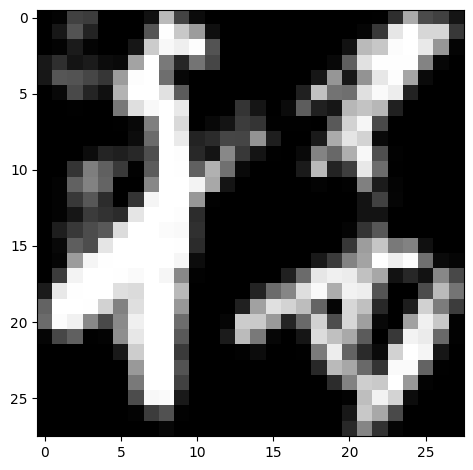

In [41]:
#   from models that trained on 28x28 images, the Kanji images must be downscaled accordingly.
import os
from skimage import io

temp_ndarray = k49_test_images[1]
    
io.imshow(temp_ndarray)
io.imsave('./RANDOMIMAGE.png', temp_ndarray)

In [154]:
test_image_dir = None
test_image_dir = tf.keras.utils.image_dataset_from_directory('.', seed=222, subset="training",
                            color_mode="grayscale", validation_split=0.3, image_size=(64, 64), interpolation="mitchellcubic")

Found 10 files belonging to 8 classes.
Using 7 files for training.


In [155]:
test_images_data_object = list(test_image_dir.as_numpy_iterator())
prefix = "test_interp_dir\\"

for elem in test_images_data_object:
    for num in range(7):
        path = prefix + f"test{num}.png"
        picture = elem[0][num]
        picture = np.uint8(np.interp(picture, (picture.min(), picture.max()), (0, 255)))
        
        io.imsave(path, picture)
print("Done!")

Done!


BICUBIC


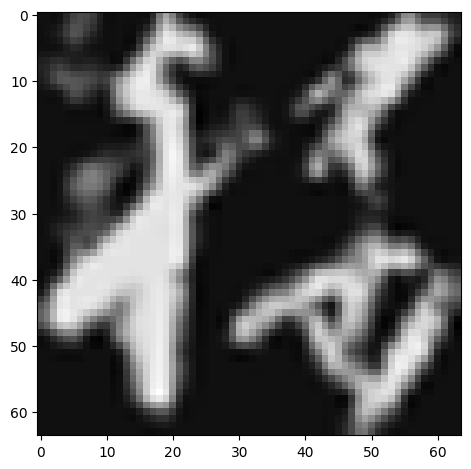

In [122]:
print("BICUBIC")
io.imshow(prefix + "test2.png")

LANCZOS5


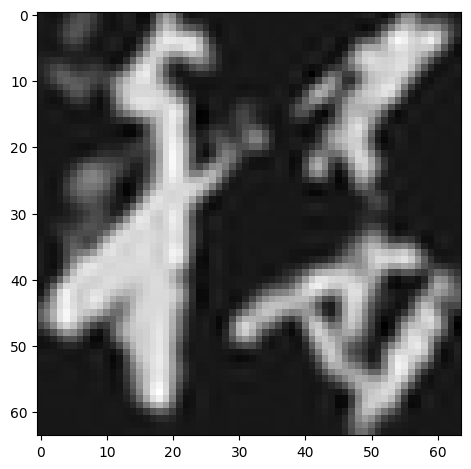

In [150]:
print("LANCZOS5")
io.imshow(prefix + "test2.png")